In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
from collections import namedtuple
from collections import OrderedDict
import copy
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import naive_bayes

In [2]:
claims_fp = "/Users/eotles/Box Sync/ISyE417_S15/W13/ML Activity/Claims_Y1.csv"
member_fp = "/Users/eotles/Box Sync/ISyE417_S15/W13/ML Activity/Members_Y1.csv"
label_fp = "/Users/eotles/Box Sync/ISyE417_S15/W13/ML Activity/DayInHospital_Y2.csv"
train_fp = "/Users/eotles/Box Sync/ISyE417_S15/W13/ML Activity/Train_DayInHospital_Y2.csv"
test_fp  = "/Users/eotles/Box Sync/ISyE417_S15/W13/ML Activity/Test_List.csv"

In [3]:
class colDefn(object):
    def __init__(self, kind):
        self.kind = kind

class pt_db(object):
    def __init__(self, fp, id_col, cols):
        self._loadData(fp, id_col, cols)
        #self.pt_data = pt_data
        #self.feat_groups = feat_groups
        
    def _loadData(self, fp, id_col, cols):
        data_file = open(fp)
        data_header = next(data_file).strip().split(',')
        pt_data = dict()
        feat_groups = {data_header[x]: set() for x in cols}

        for idx, data_line in enumerate(data_file):
            data_line = data_line.strip().split(',')
            pID = data_line[id_col]
            if(pt_data.has_key(pID) == False):
                pt_data[pID] = dict()
            #just doing counts now!
            for col_idx, col_defn in cols.iteritems():
                feat = data_header[col_idx]
                feat_val = data_line[col_idx]
                
                if(col_defn.kind == "count"):
                    info_key = ("%s: %s" %(feat, feat_val))
                    if(pt_data[pID].has_key(info_key) == False): pt_data[pID][info_key] = 1
                    else: pt_data[pID][info_key] += 1
                    feat_groups[feat].add(feat_val)
                elif(col_defn.kind == "first"):
                    if(pt_data[pID].has_key(feat) == False): pt_data[pID][feat] = feat_val 

            #if(idx>100000): break

        data_file.close()
        self.pt_data = pt_data
        self.feat_groups = feat_groups
        self.deDuplicate()
    
    def deDuplicate(self):
        for feat, vals in self.feat_groups.iteritems():
            if(len(vals) == 2):
                rem_val = vals.pop()
                rem_key = ("%s: %s" %(feat, rem_val))
                for pID, pt in self.pt_data.iteritems():
                    if(pt.has_key(rem_key) == True): pt.pop(rem_key)
    
    def merge(self, pt_db):
        for pID, mergePt in pt_db.pt_data.iteritems():
            if(self.pt_data.has_key(pID) == True):
                self.pt_data[pID].update(mergePt)
        self.feat_groups.update(pt_db.feat_groups)
    
    def getInfoKeys(self):
        info_keys = list()
        for feat, feat_vals in iter(sorted(self.feat_groups.iteritems())):
            if(len(feat_vals) == 0):
                info_keys.append(feat)
            else:
                for feat_val in sorted(feat_vals):
                    info_key = ("%s: %s" %(feat, feat_val))
                    info_keys.append(info_key)
        return(info_keys)
    
    def toList(self):
        pt_list = dict()
        info_keys = self.getInfoKeys()
        for pID, pt in self.pt_data.iteritems():
            ptList = [pt[info_key] if(pt.has_key(info_key) == True) else 0 for info_key in info_keys]
            pt_list[pID] = ptList
            #print(ptList)
        return(pt_list, info_keys)
        
        

claims_indices = [5, 6, 8, 10, 11]
member_indices = [1, 2]

claims_cols = {x: colDefn("count") for x in claims_indices}
member_cols = {x: colDefn("count") for x in member_indices}
label_cols = {1: colDefn("first")}

claims_db = pt_db(claims_fp, 0, claims_cols)
member_db = pt_db(member_fp, 0, member_cols)
claims_db.merge(member_db)
member_db = None

label_db = pt_db(label_fp, 0, label_cols)

data_db_list, data_db_info_keys = claims_db.toList()
label_db_list, _ = label_db.toList()

claims_db = None
label_db = None

In [4]:
splits = {'train': open(train_fp), 'test': open(test_fp)}
data = {'x': dict(), 'y': dict()}
for split, split_list in splits.iteritems():
    next(split_list)
    temp = dict({'x': list(), 'y': list()})
    for row in split_list:
        row = row.strip().split(',')
        pID = row[0]
        temp['x'].append(data_db_list[pID])
        temp['y'].append(float(label_db_list[pID][0]))
        
    data['x'].update({split : temp['x']})
    data['y'].update({split : temp['y']})
       
for j in data['x']:
    data['x'][j] = np.array(data['x'][j], dtype = 'float_')

In [5]:
featMap = {}
for idx, info_key in enumerate(data_db_info_keys):
    c_pos = info_key.find(':')
    feat_group = info_key[:c_pos]
    if(featMap.has_key(feat_group) == False):
        featMap.update({feat_group: list()})
    featMap[feat_group].append(idx)

In [6]:
Learner = namedtuple("Learner", ['model', 'params'])

#take split data up
#learn best hyperparameters for each type of reg. model.
def reg(data):        
    kf = cross_validation.KFold(len(data["x"]["train"]), n_folds=10, random_state=42)
    
    learners = OrderedDict()
    #learners["SGDRegressor"] = Learner(linear_model.SGDRegressor(), None)
    learners["Linear Regression"] = Learner(linear_model.LinearRegression(n_jobs=-1), None)
    learners["RidgeCV"] = Learner(linear_model.RidgeCV(cv=kf), None)
    learners["LassoCV"] = Learner(linear_model.LassoCV(cv=kf, n_jobs=-1), None)
    #learners["BayesianRidge"] = Learner(linear_model.BayesianRidge(), None)
    ##learners["LarsCV"] = Learner(linear_model.LarsCV(cv=kf, n_jobs=-1), None)
    ##learners["LassoLarsCV"] = Learner(linear_model.LassoLarsCV(cv=kf, n_jobs=-1), None)
    #learners["ElasticNetCV"] = Learner(linear_model.ElasticNetCV(cv=kf, n_jobs=-1), None)
    #learners["OrthogonalMatchingPursuitCV"] = Learner(linear_model.OrthogonalMatchingPursuitCV(cv=kf, n_jobs=-1), None)
    #learners["KNeighborsRegressor"] = Learner(neighbors.KNeighborsRegressor(), None)
    learners["DecisionTreeRegressor"] = Learner(tree.DecisionTreeRegressor(), None)
    learners["RandomForestRegressor"] = Learner(ensemble.RandomForestRegressor(), None)
    learners["ExtraTreesRegressor"] = Learner(ensemble.ExtraTreesRegressor(), None)
    ##learners["GaussianProcess"] = Learner(gaussian_process.GaussianProcess(), None)
    #memory error
    
    for name, learner in learners.iteritems():
        #print("### Learning & Evaluating %s ###" %(name))
        if(learner.params != None):
            print("\tGrid searching hyper-parameters...")
            reg = grid_search.GridSearchCV(learner.model, learner.params, cv=5)
            reg.fit(data["x"]["train"], data["y"]["train"])
            print("\tBest parameters found on train set:")
            print("\t%s" %(reg.best_params_))
        else:
            reg = learner.model
            reg.fit(data["x"]["train"], data["y"]["train"])
            pred = {"train": reg.predict(data["x"]["train"]), "test": reg.predict(data["x"]["test"])}
            reg_eval2(name, data, pred)
            reg = None

            
def reg_eval2(name, data, pred):
    splot = {i:{} for i in ["scatter", "histo"]}
    f, ((splot["scatter"]["train"], splot["scatter"]["test"]), (splot["histo"]["train"], splot["histo"]["test"])) = plt.subplots(2,2, figsize=(15,8))
    all_labl = data["y"]["train"] + data["y"]["test"]
    labl_max = max(all_labl)
    labl_min = min(all_labl, 0)
    for i in ["train", "test"]:
        y_true = data["y"][i]
        y_pred = pred[i]
        splot["scatter"][i].scatter(data["y"][i], pred[i])
        splot["scatter"][i].set_xlim(labl_min,labl_max)
        splot["scatter"][i].set_ylim(labl_min,labl_max)
        splot["scatter"][i].set_title("%s\nR2: %0.3f,  |Err|: %0.3f,  Err^2: %0.3f,  MedEr: %0.3f\n" %(i, metrics.r2_score(y_true, y_pred), 
                                                                                     metrics.mean_absolute_error(y_true, y_pred),
                                                                                     metrics.mean_squared_error(y_true, y_pred),
                                                                                     metrics.median_absolute_error(y_true, y_pred)),
                                                                                    fontsize=10)

        dif = data["y"][i] - pred[i]
        splot["histo"][i].hist(dif, 50, normed=True)
        splot["histo"][i].set_xlim(-20,20)
        splot["histo"][i].set_ylim(0,0.005)
        splot["histo"][i].set_title("%0.3f, %0.3f" %(np.mean(dif), np.std(dif)))
    
    f.suptitle(name, fontsize=20)
    plt.show()

    
def clf(data):
    kf = cross_validation.KFold(len(data["x"]["train"]), n_folds=10, random_state=42)
    
    learners = OrderedDict()
    learners["LogisticRegression"] = Learner(linear_model.LogisticRegression(), None)
    learners["DecisionTreeClassifier"] = Learner(tree.DecisionTreeClassifier(), None)
    learners["RandomForestClassifier"] = Learner(ensemble.RandomForestClassifier(), None)
    learners["GaussianNB"] = Learner(naive_bayes.GaussianNB(), None)
    learners["SGD"] = Learner(linear_model.SGDClassifier(), None)
    #learners["SVC"] = Learner(svm.SVC(), None)
    #learners["ExtraTreesClassifier"] = Learner(ensemble.ExtraTreeClassifier(), None)
    
    for name, learner in learners.iteritems():
        #print("### Learning & Evaluating %s ###" %(name))
        if(learner.params != None):
            print("\tGrid searching hyper-parameters...")
            clf = grid_search.GridSearchCV(learner.model, learner.params, cv=5)
            clf.fit(data["x"]["train"], data["y"]["train"])
            print("\tBest parameters found on train set:")
            print("\t%s" %(reg.best_params_))
        else:
            clf = learner.model
            clf.fit(data["x"]["train"], data["y"]["train"])
            pred = {"train": clf.predict(data["x"]["train"]), "test": clf.predict(data["x"]["test"])}
            clf_eval(name, data, pred)
            clf = None

        
def clf_eval(name, data, pred):
    splot = dict()
    f, (splot["train"], splot["test"]) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,8))
    all_labl = data["y"]["train"] + data["y"]["test"]
    labl_max = max(all_labl)
    labl_min = min(all_labl, 0)
    for i in ["train", "test"]:
        y_true = data["y"][i]
        y_pred = pred[i]
        
        img = splot[i].imshow(metrics.confusion_matrix(y_true, y_pred), interpolation='nearest', cmap=plt.cm.Blues)
        splot[i].set_ylabel('True label')
        splot[i].set_xlabel('Predicted label')
        
        
        #splot[i].scatter(data["y"][i], pred[i])
        #splot[i].set_xlim(labl_min,labl_max)
        #splot[i].set_ylim(labl_min,labl_max)
        splot[i].set_title("%s\nAcc: %0.3f,  Pre: %0.3f,  Rec: %0.3f,  MedEr: ?\n" %(i, metrics.accuracy_score(y_true, y_pred), 
                                                                                     metrics.precision_score(y_true, y_pred),
                                                                                     metrics.recall_score(y_true, y_pred)),
                                                                                        fontsize=10)
    f.subplots_adjust(right=0.8)
    #cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.colorbar(img)
    f.suptitle(name, fontsize=20)
    plt.show()

def simple_reg(data):
    for feat_group, col_list in sorted(featMap.iteritems()):
        tempLR = linear_model.LinearRegression()
        if(len(col_list)>1):
            x_train = data["x"]["train"][:,col_list]
            x_test = data["x"]["test"][:,col_list]
        else:
            x_train = data["x"]["train"][:,col_list[0]:col_list[0]+1]
            x_test = data["x"]["test"][:,col_list[0]:col_list[0]+1] 
        tempLR.fit(x_train, data["y"]["train"])
        pred = {"train": tempLR.predict(x_train), "test": tempLR.predict(x_test)}           
        reg_eval2(feat_group, data, pred)
           
def simple(data):
    print("-----Simple Feature Tests-----")
    for col_i in xrange(data["x"]["train"].shape[1]):
        #print("\tFeature: %s" %(feat[col_i]))
        tempLR = linear_model.LinearRegression()
        x_train = (data["x"]["train"][:,col_i:col_i+1])
        x_test = (data["x"]["test"][:,col_i:col_i+1])
        tempLR.fit(x_train, data["y"]["train"])
        pred = {"train": tempLR.predict(x_train), "test": tempLR.predict(x_test)}           
        reg_eval2(feat[col_i], data, pred)

In [7]:
def runLearners(split_data):
    print("Data split into train(%s) and test(%s)\n" %(len(split_data["x"]["train"]), len(split_data["x"]["test"])))
    print("Regression")
    simple_reg(split_data)
    reg(split_data)

    #data['y'][split] = [1 if(val>0) else 0 for val in data['y'][split]]
    class_data = copy.copy(split_data)
    for split in ['train', 'test']:
        class_data['y'][split] = [1 if(val>0) else 0 for val in split_data['y'][split]]
    
    print("Data split into train(%s) and test(%s)\n" %(len(class_data["x"]["train"]), len(class_data["x"]["test"])))
    print("Classification")
    clf(class_data)

Data split into train(38453) and test(38836)

Regression


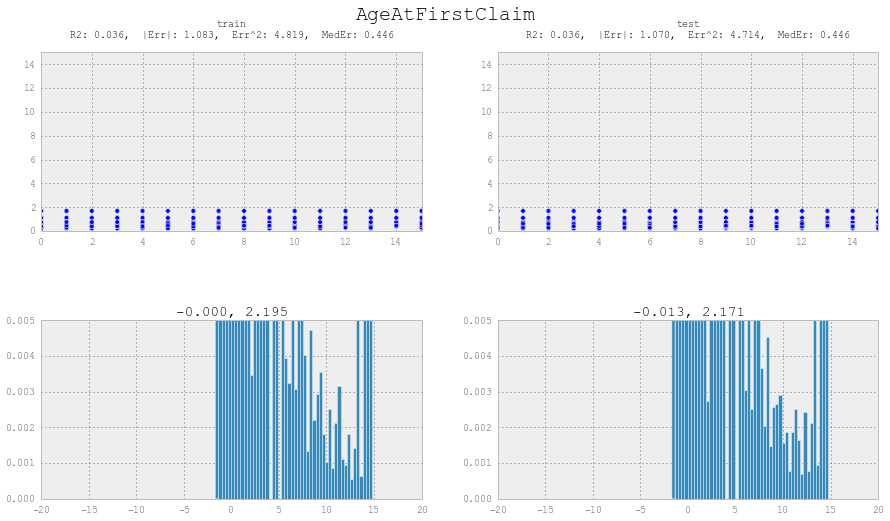

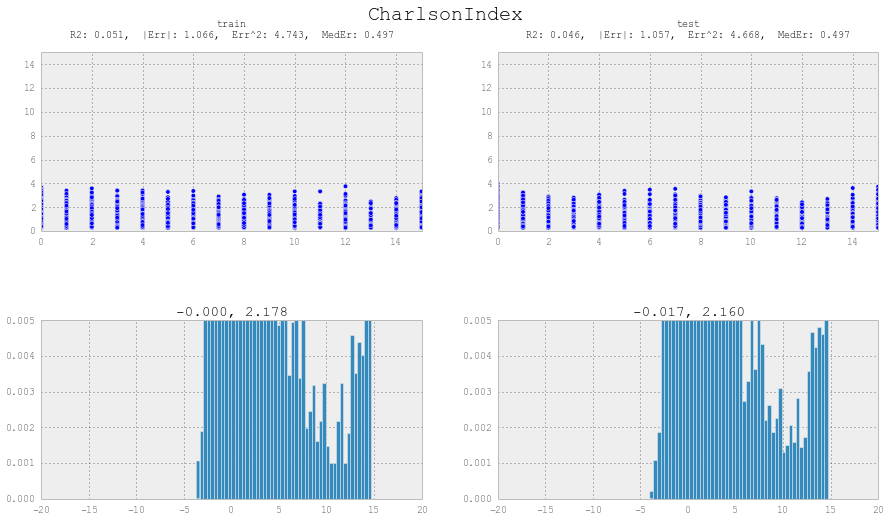

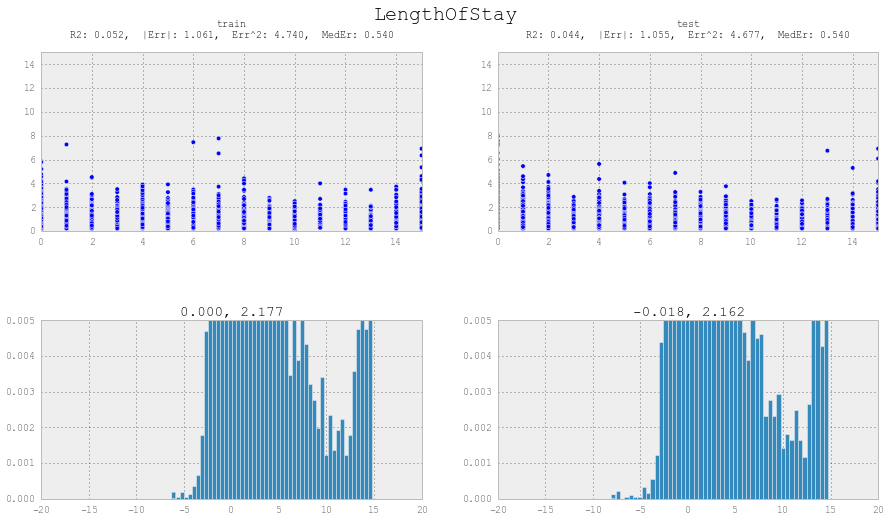

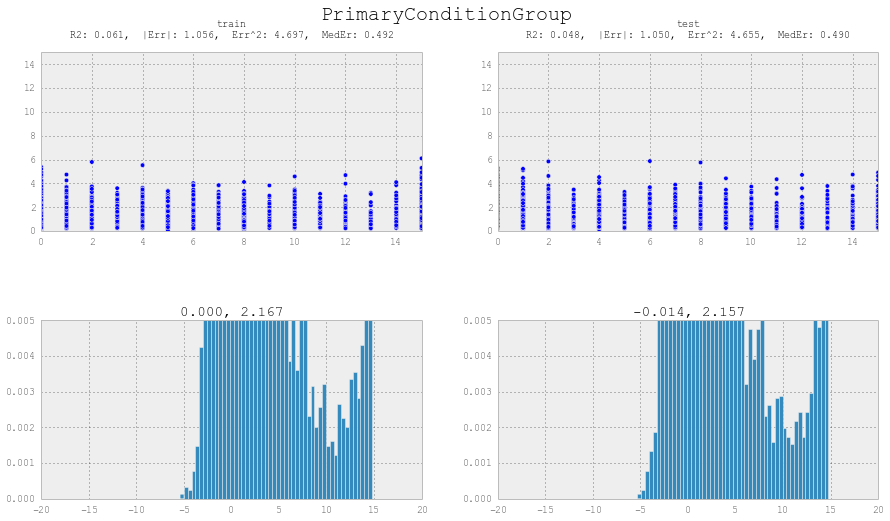

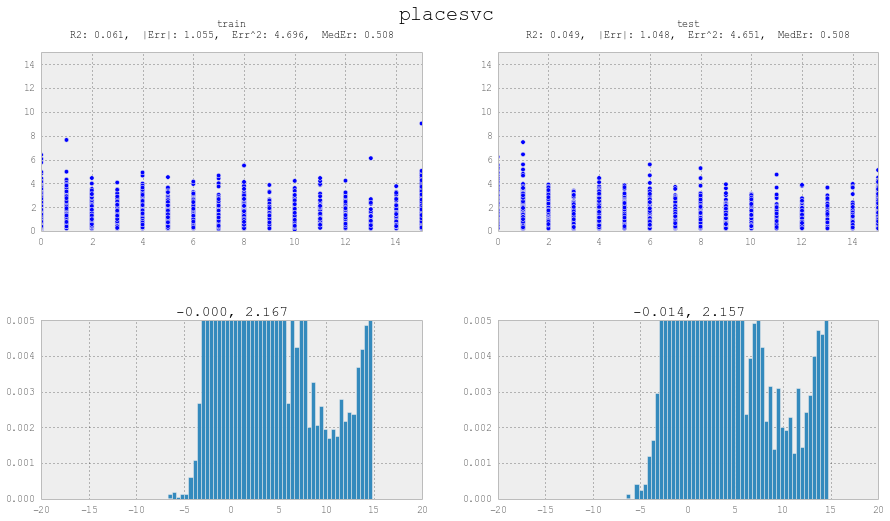

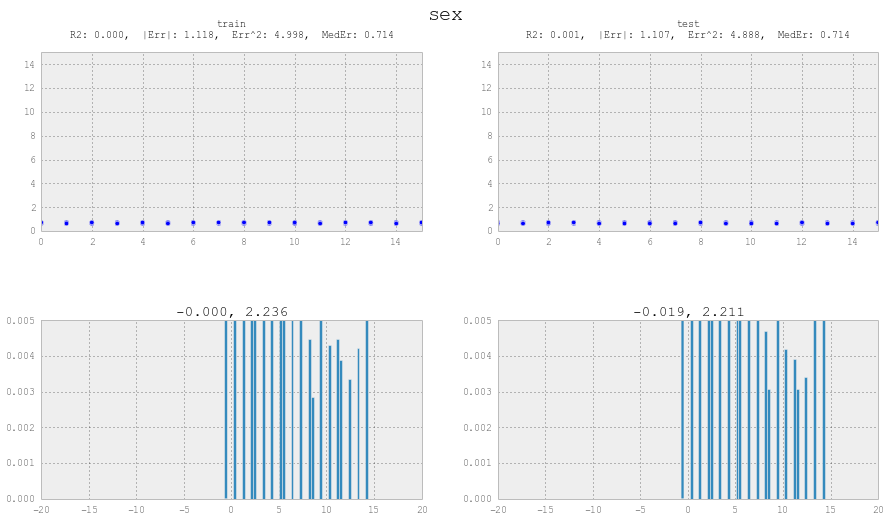

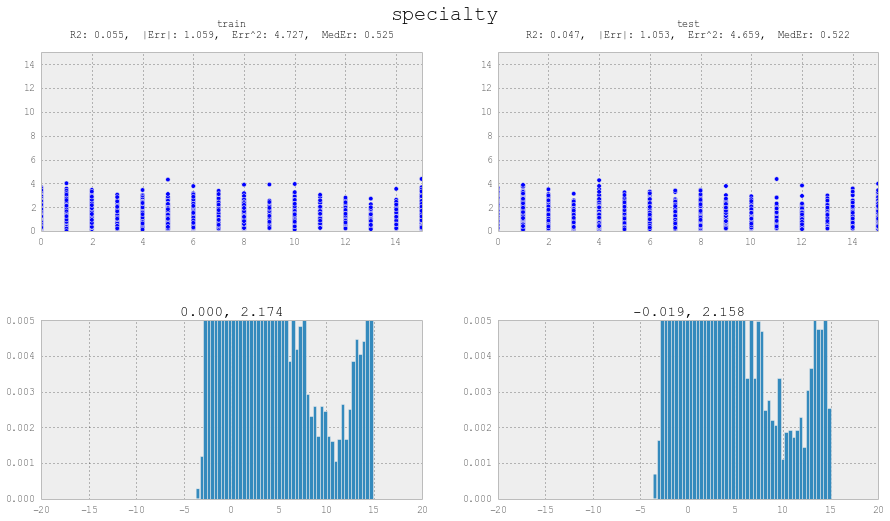

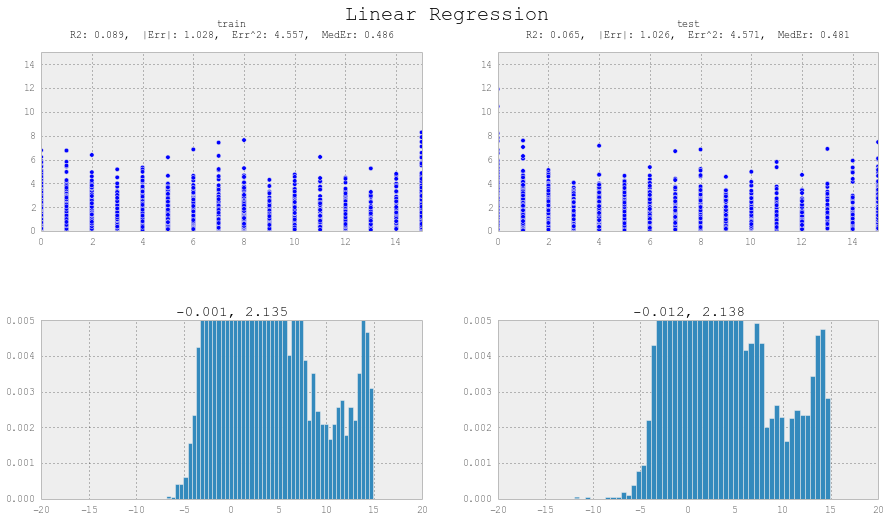

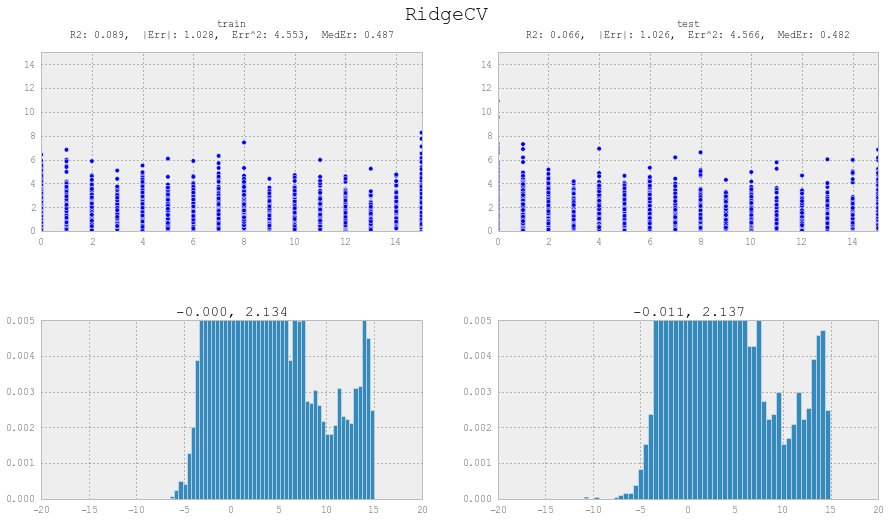

/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


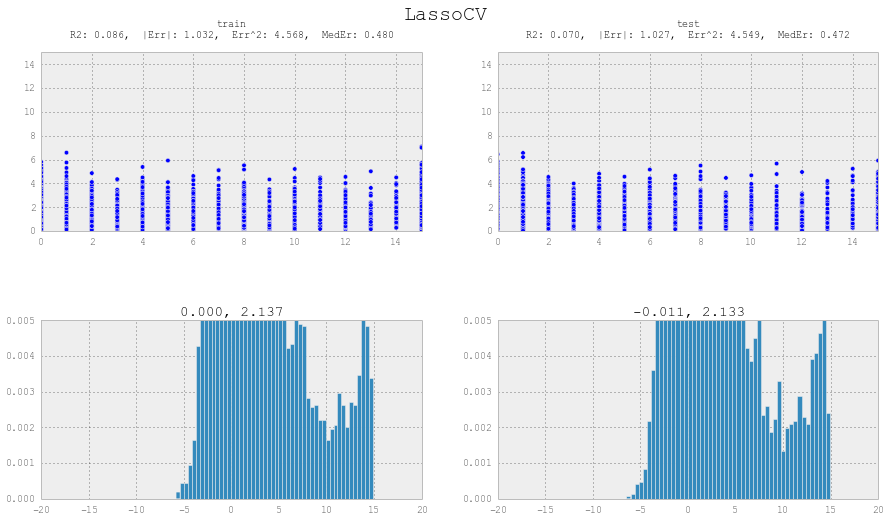

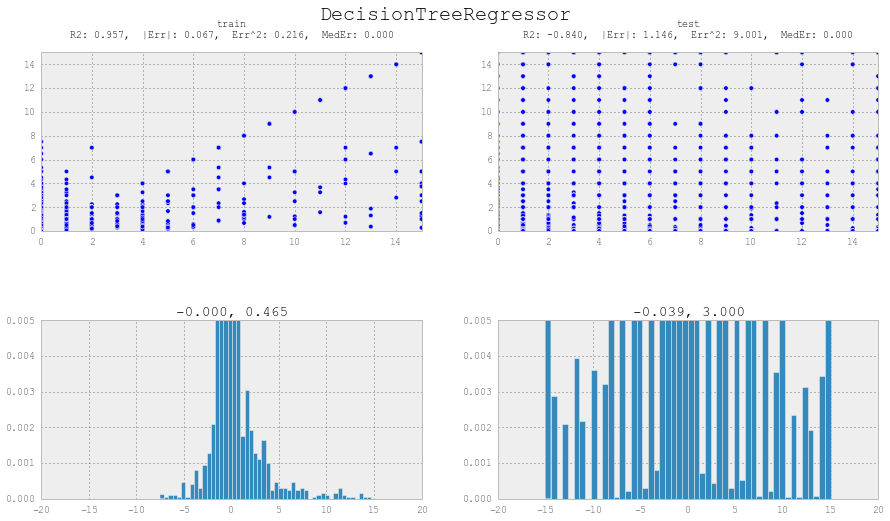

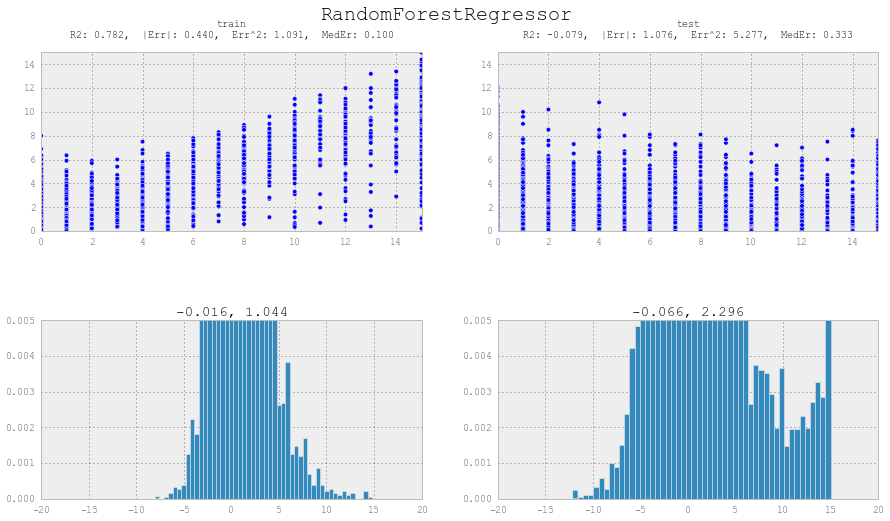

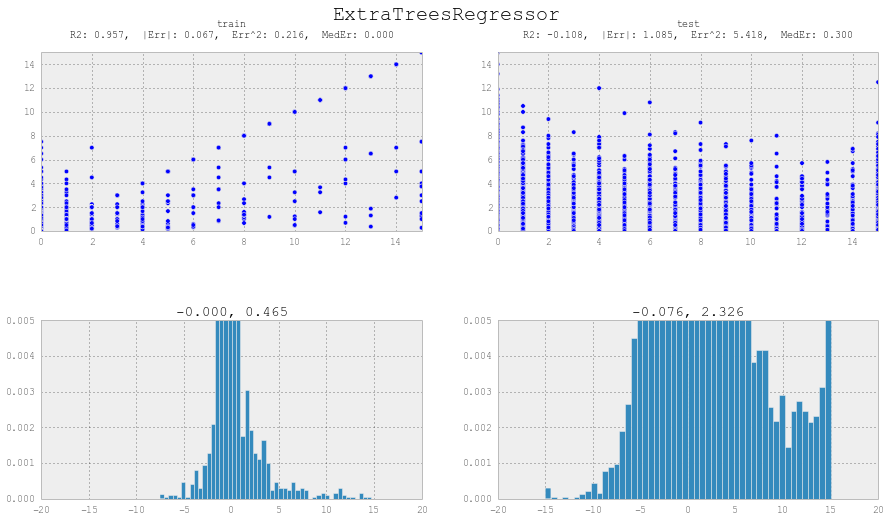

Data split into train(38453) and test(38836)

Classification


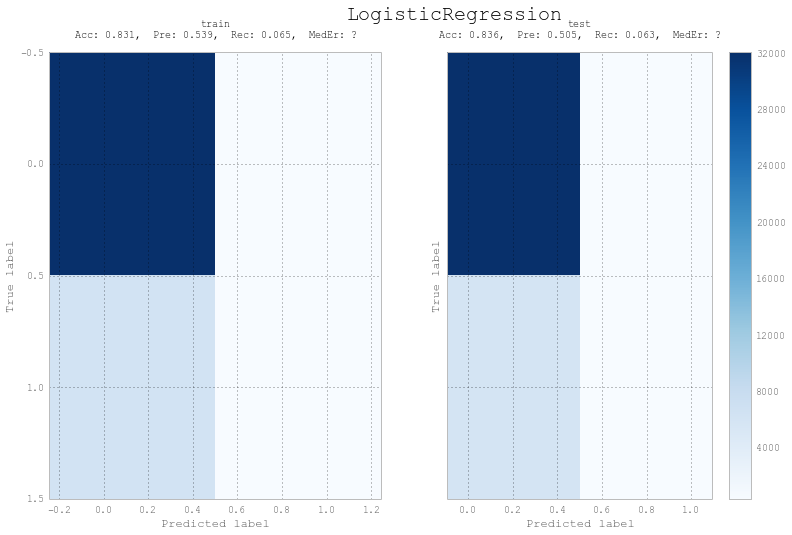

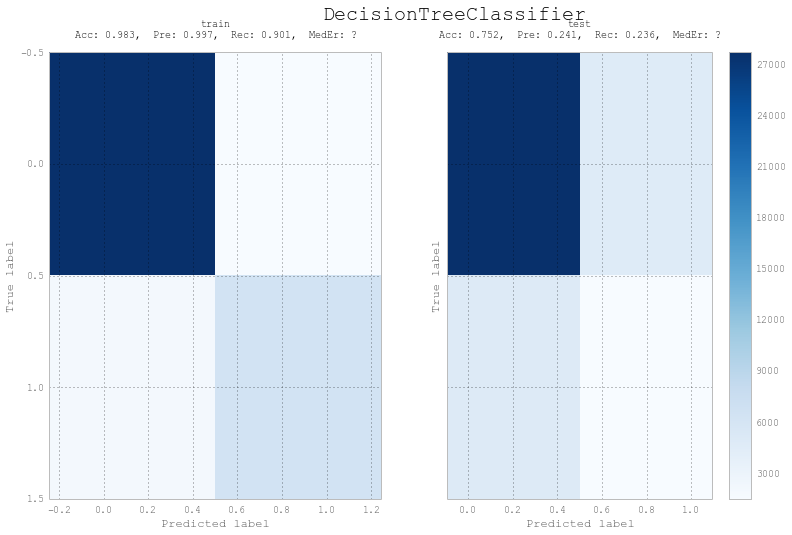

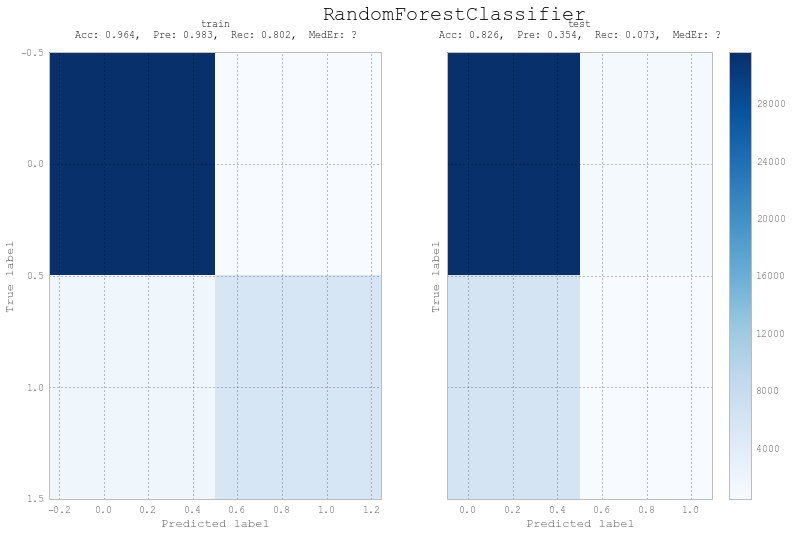

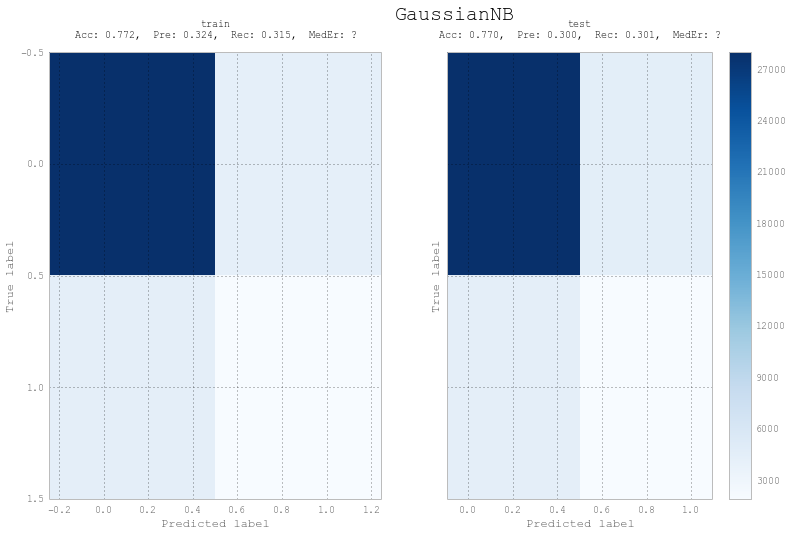

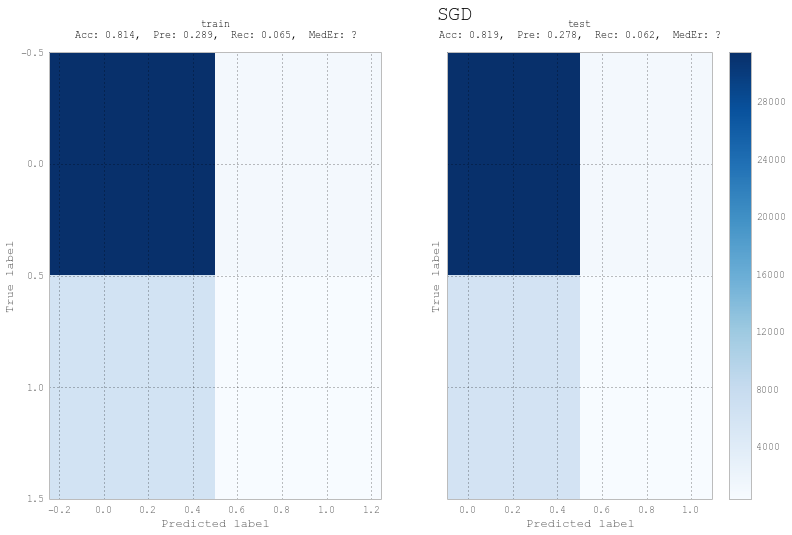

In [8]:
runLearners(data)